### Darcy Advect-diffuse net

Implement the MR-AIV pipeline in [J. D. Toscano et al. 2025](https://doi.org/10.1101/2025.07.30.667741) using pytorch + lightning.

In [25]:
# First choose a config file to apply
config_path = "configs/dcpinn_full_runtest.yaml"

#### 1. Data preparation

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch

torch.set_float32_matmul_precision('medium')

from modules.dc_net import AD_DC_Net
from modules.data_module import CharacteristicDomain, DCEMRIDataModule, VelocityDataModule, PermeabilityDataModule
from modules.filtered_modules import create_outlier_filter_mask, FilteredDCEMRIDataModule

from utils.config_loader import Train_Config
from utils.train_wrapper import train_all_phases
from utils.visualize import draw_nifti_slices_with_time, draw_nifti_slices_with_threshold, interactive_quiver
from utils.io import load_dcemri_data, save_velocity_mat, load_DTI
%matplotlib widget
%load_ext autoreload
%autoreload 2

# load cfg from yaml path.
cfg = Train_Config(config_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [27]:

data,mask,pixdim,x,y,z,t = load_dcemri_data(cfg.dcemrinp_data_path)

char_domain = CharacteristicDomain(data.shape, mask, t, pixdim, device)

print("L_star: ",char_domain.L_star, "T_star: ", char_domain.T_star)
# batch_size is sum over data's point
c_dataset = DCEMRIDataModule(data, char_domain,  
                           batch_size=int(mask.sum()*len(t)), num_workers=cfg.dataset_num_workers, device=device)

# set up to get num_train_points
c_dataset.setup()
print("num_train_points: ", c_dataset.num_train_points, "batch_size: ", c_dataset.batch_size)

data_shape:  (83, 104, 83, 18) pixdim:  [0.1923077 0.1923077 0.1923077]
domain_shape:  (83,) (104,) (83,) (18,)
min_c:  0.0 max_c:  347.50098
L_star:  [7.88461553 9.90384633 7.88461553] T_star:  34.0
num_train_points:  588807 batch_size:  1177614


In [28]:
if cfg.use_DTI:
    DTI_tensor,DTI_MD = load_DTI(char_domain, cfg.dti_data_path, data.shape[:3])
else:
    DTI_tensor = None

char_domain.set_DTI_or_coef(DTI_tensor if cfg.use_DTI else 2.4e-4)
print("Pe_g: ", char_domain.Pe_g)

Original DTI shape:  (128, 160, 128, 3, 3)
Resized DTI shape:  (83, 104, 83, 3, 3)
DTI_MD min:  0.0005106272672108025 DTI_MD max:  0.028975239846615278 DTI_MD mean:  0.006482387615785588
Pe_g:  0.7179813750214857


In [ ]:
if cfg.use_DTI:
    draw_nifti_slices_with_threshold(DTI_MD, brain_mask=mask, slice_along_axis='x')

Volume shape: (83, 104, 83) dtype: float64


interactive(children=(IntSlider(value=41, description='Slice X', max=82), FloatSlider(value=0.0147429331555031…

In [30]:
# use front-tracking to get initial velocity field.
from utils.velocity_guess import front_tracking_velocity
# shape (nx, ny, nz, 3), only use half of data for estimation, unit in cell/min
initial_velocity_field = front_tracking_velocity(data[:,:,:,::2], 
                                                 dt=t[2] - t[0])

# draw initial velocity magnitude
vel_mag = np.linalg.norm(initial_velocity_field, axis=-1)
# print(pixdim, char_domain.domain_shape, char_domain.L_star, char_domain.T_star, char_domain.V_star)
print("velocity max and min: ", vel_mag.max(), vel_mag.min())
draw_nifti_slices_with_threshold(vel_mag)

v_dataset = VelocityDataModule(initial_velocity_field, char_domain,
                              batch_size=int(mask.sum()), num_workers=cfg.dataset_num_workers, device=device)
# scaling, front tracking give unit in cell/min, we need to scale to characteristic velocity

# set up to get num_train_points
v_dataset.setup()

velocity max and min:  0.3307868200912859 0.0
Volume shape: (83, 104, 83) dtype: float64


interactive(children=(IntSlider(value=41, description='Slice Z', max=82), FloatSlider(value=0.1653934121131897…

interactive(children=(IntSlider(value=3, description='Stride', max=10, min=1), IntSlider(value=25, description…

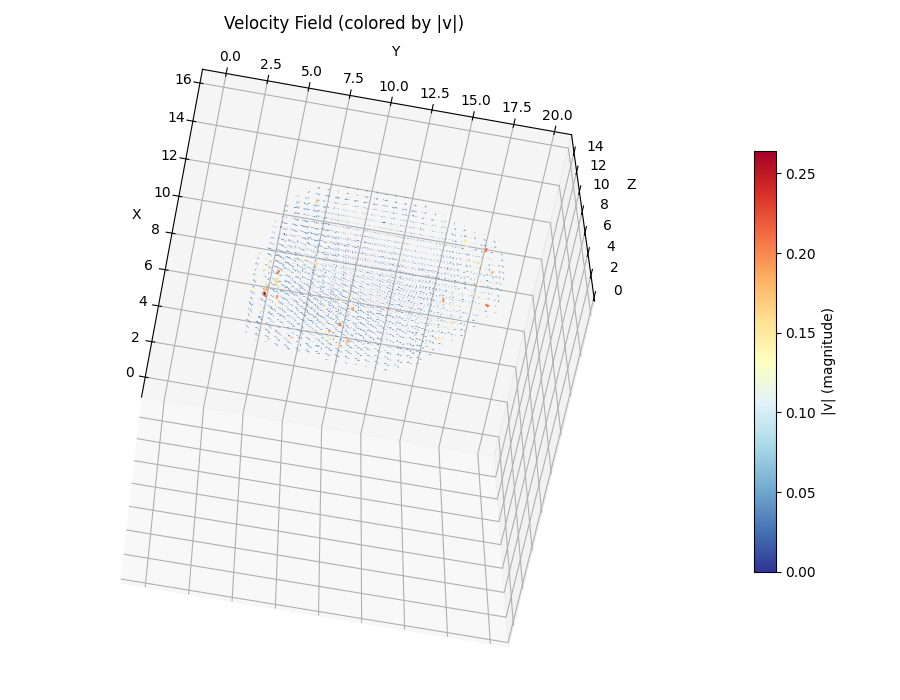

In [31]:
interactive_quiver(initial_velocity_field[:,:,:,0], initial_velocity_field[:,:,:,1], 
                   initial_velocity_field[:,:,:,2], char_domain.pixdim,default_elev=-62.76, default_azim=-10.87)


In [32]:
from utils.permeability_guess import estimate_initial_permeability

initial_permeability, smooth_permeability = estimate_initial_permeability(data, t, ser_threshold=12.0,
                                                     time_threshold_min=t[4])
print("Initial permeability max and min: ", smooth_permeability.max(), smooth_permeability.min())
draw_nifti_slices_with_threshold(smooth_permeability, brain_mask=mask)
# prepare permeability datamodule, according to the paper,
# "smooth" initial permeability guess is almost certainly the better and safer choice for initializing the NN_k network
k_dataset = PermeabilityDataModule(smooth_permeability, char_domain,
                                  batch_size=int(mask.sum()), num_workers=cfg.dataset_num_workers, device=device)


Initial permeability max and min:  1e-06 1e-10
Volume shape: (83, 104, 83) dtype: float32


interactive(children=(IntSlider(value=41, description='Slice Z', max=82), FloatSlider(value=5.000499987382889e…

#### 2. Network definition


In [33]:
from modules.c_trainer import CNet_Init, CNet_DenoiseInit

from modules.dc_trainer import DCPINN_InitK, DCPINN_InitP, DCPINN_ADPDE_P, DCPINN_ADPDE_P_K, DCPINN_Joint

# write a trainner getter to factorize.

def DCPINN_trainer_getter(train_phase, ad_dc_net, phase_cfg={}):
    global c_dataset
    incompressible = phase_cfg.get("incompressible", False)
    if train_phase == CNet_Init.train_phase:
        pinn_model = CNet_Init(ad_dc_net.c_net, c_dataset.num_train_points)
        datamodule = c_dataset
    elif train_phase == CNet_DenoiseInit.train_phase:
        pinn_model = CNet_DenoiseInit(ad_dc_net.c_net, c_dataset.num_train_points)
        datamodule = c_dataset
    elif train_phase == DCPINN_InitK.train_phase:
        pinn_model = DCPINN_InitK(ad_dc_net, k_dataset.num_train_points)
        datamodule = k_dataset
    elif train_phase == DCPINN_InitP.train_phase:
        pinn_model = DCPINN_InitP(ad_dc_net, v_dataset.num_train_points)
        datamodule = v_dataset
    elif train_phase == "filter":
        batch_size = phase_cfg.get("batch_size", 200_000)
        # filter means filter on c_dataset.
        ad_dc_net.c_net.to(device)
        valid_mask = create_outlier_filter_mask(ad_dc_net.c_net, c_dataset.X_train, cfg.result_folder, batch_size)
        c_dataset = FilteredDCEMRIDataModule(c_dataset, valid_mask)
        c_dataset.setup() # setup to get actual train_num_points
        pinn_model = None
        datamodule = c_dataset
    elif train_phase == DCPINN_ADPDE_P.train_phase:
        pinn_model = DCPINN_ADPDE_P(ad_dc_net, c_dataset.num_train_points, incompressible=incompressible)
        datamodule = c_dataset
    elif train_phase == DCPINN_ADPDE_P_K.train_phase:
        pinn_model = DCPINN_ADPDE_P_K(ad_dc_net, c_dataset.num_train_points, incompressible=incompressible)
        datamodule = c_dataset
    elif train_phase == DCPINN_Joint.train_phase:
        pinn_model = DCPINN_Joint(ad_dc_net, c_dataset.num_train_points, incompressible=incompressible)
        datamodule = c_dataset
    else:
        raise ValueError(f"Unknown train_phase {train_phase}")
    return pinn_model, datamodule


In [34]:
P_star = np.mean(char_domain.V_star * cfg.viscosity * char_domain.L_star / k_dataset.K_star)
print("P_star: ", P_star)

P_star:  151551.22039552906


#### 3. Training step

- first we has initializaiton for c and k net
- then use Darcy's law to initalize p throught front tracking velocity guess
- optimization p / p + k net through advect diffuse function.
- joint optimize p + k + c net through data loss and advect diffuse.

In [35]:
# Instantiate the model and trainer or load from checkpoint:
ad_dc_net = AD_DC_Net(c_layers=[4] + [cfg.c_neuron_num for _ in range(cfg.hid_layer_num)] + [1],
        k_layers=[3] + [cfg.neuron_num for _ in range(cfg.hid_layer_num)] + [1], # if anisotropic, change to 3 output
        p_layers=[3] + [cfg.neuron_num for _ in range(cfg.hid_layer_num)] + [1],
        data=data, char_domain=char_domain, C_star=c_dataset.C_star,
        K_star=k_dataset.K_star, P_star=P_star,
        positional_encoding=cfg.use_positional_encoding,
        freq_nums=cfg.positional_encode_nums,
        gamma_space=cfg.position_encode_freq_scale,
        use_learnable_D=cfg.use_learnable_D,)

if cfg.do_training:
    pinn_model = train_all_phases(ad_dc_net, DCPINN_trainer_getter, cfg)
else:
    checkpoint = torch.load(cfg.ckpt_path, map_location="cpu")
    if "state_dict" in checkpoint and "train_phase" in checkpoint:
        pinn_model = DCPINN_trainer_getter(checkpoint.get("train_phase"), ad_dc_net)[0]
        pinn_model.load_state_dict(checkpoint['state_dict'], strict=True)
    else:
        pinn_model = DCPINN_Joint(ad_dc_net, c_dataset.num_train_points)
        ad_dc_net.load_state_dict(checkpoint['state_dict'], strict=False)


# After training, visualize the learned velocity field and diffusivity
# Extract learned parameters
D_learned = pinn_model.ad_dc_net.D.item()

print(f"Learned diffusivity D: {D_learned}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | ad_dc_net | AD_DC_Net | 404 K  | train
1 | L2_loss   | MSELoss   | 0      | train
------------------------------------------------
109 K     Trainable params
295 K     Non-trainable params
404 K     Total params
1.619     Total estimated model params size (MB)
33        Modules in train mode
15        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### 4. Visualize result.
Finally we will save the velocity mat to run GLAD (get pathline figure) in matlab.

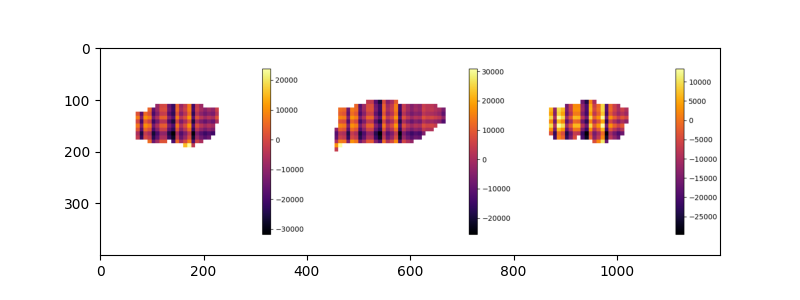

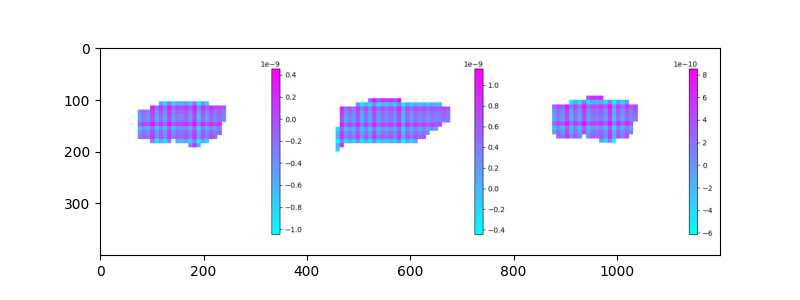

In [ ]:
# first visualize p and k fields
p_fig = pinn_model.ad_dc_net.v_dc_net.p_net.draw_physical_slices()
plt.figure(figsize=(8,3))
plt.imshow(p_fig)
k_fig = pinn_model.ad_dc_net.v_dc_net.k_net.draw_physical_slices()
plt.figure(figsize=(8,3))
plt.imshow(k_fig)

(600, 700, 3) 
vx_min:  -0.04581037 	vx_max: 0.027668769 
vy_min:  -0.070702836 	vy_max: 0.057371598 
vz_min:  -0.06278598 	vz_max: 0.066054635


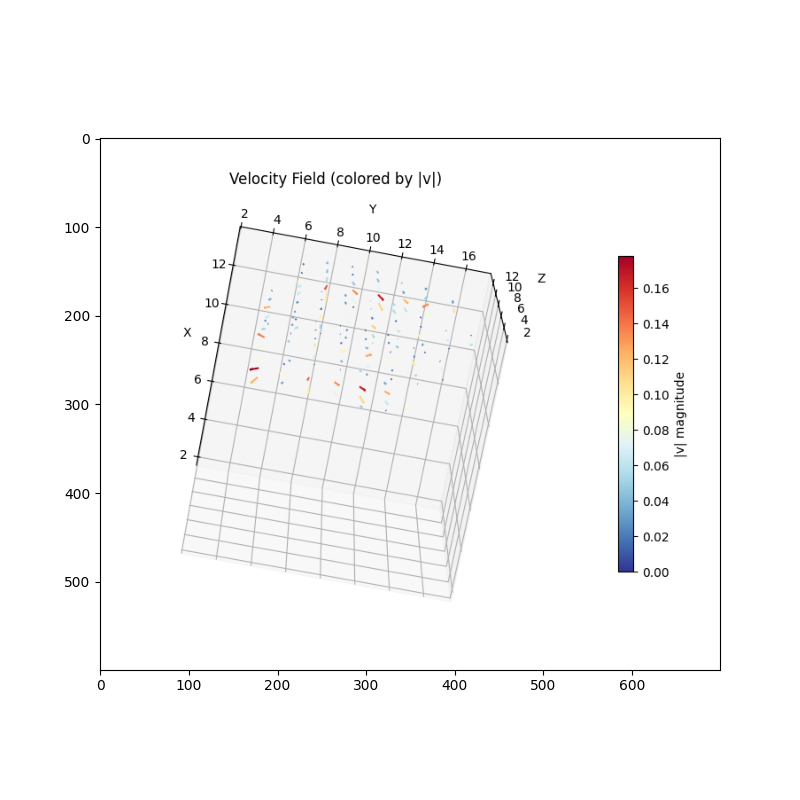

In [ ]:
# 1. Extract learned velocity field on a grid for visualization
# If run out of memory, set all variables to cpu 
# pinn_model.to('cpu')
pinn_model.to(device)
# using mask to filter out the background vectors
# _ = interactive_quiver(vx, vy, vz, pixdim, default_elev=-62.76, default_azim=-10.87)
nx, ny, nz = data.shape[0], data.shape[1], data.shape[2]
v_fig, vx,vy,vz = pinn_model.ad_dc_net.v_dc_net.draw_velocity_volume()
# change vx,vy,vz from characteristic to mm/min then cell/min
vx = vx * (char_domain.V_star[0] / char_domain.pixdim[0])
vy = vy * (char_domain.V_star[1] / char_domain.pixdim[1])
vz = vz * (char_domain.V_star[2] / char_domain.pixdim[2])
print(v_fig.shape, "\nvx_min: ", vx.min(), "\tvx_max:", vx.max(),
      "\nvy_min: ", vy.min(), "\tvy_max:", vy.max(),
      "\nvz_min: ", vz.min(), "\tvz_max:", vz.max())
plt.figure(figsize=(8,8))
plt.imshow(v_fig)
# use a grid (from real to characteristic) to extract velocity field

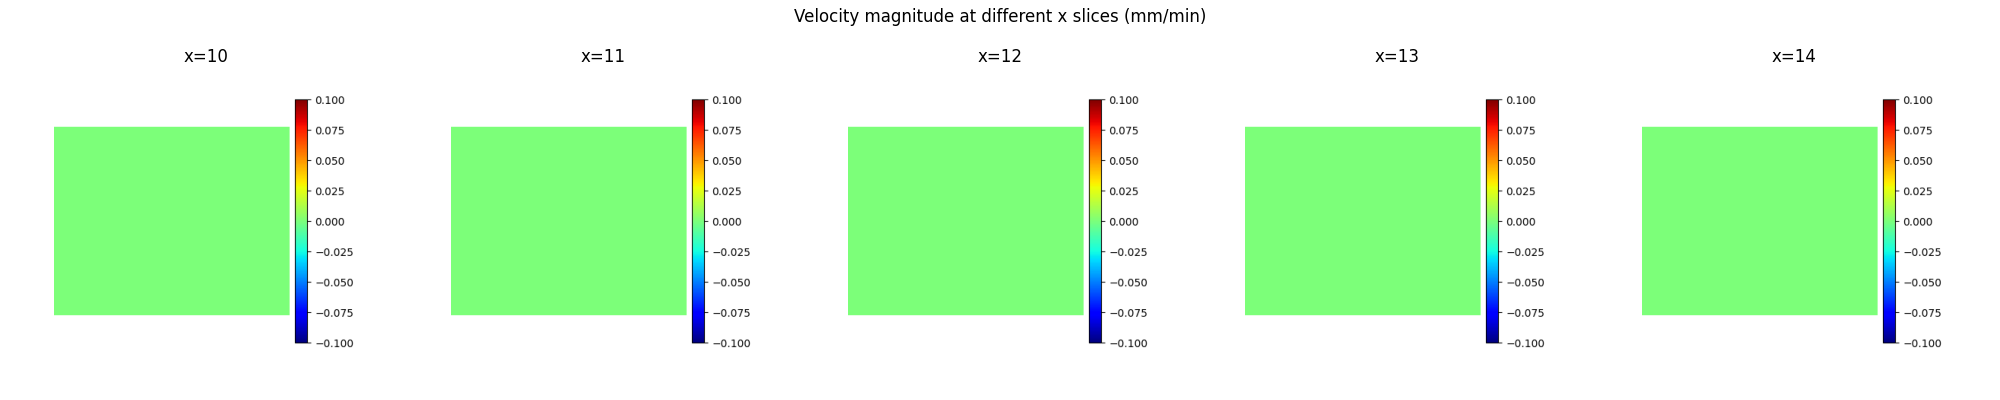

In [ ]:
# To reproduct paper, slice v_mag at x to see willis loop
from utils.visualize import draw_nifti_slices_with_threshold, draw_colorful_slice_image
v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
v_mag = v_mag.reshape((nx, ny, nz))
data_t = data[:,:,:,10]
# draw_nifti_slices_with_threshold(v_mag, brain_mask=mask, slice_along_axis='z')

slices_to_show = list(range(40, 45, 1))
# slices_to_show = list(range(10, 15, 1))
num_slices = len(slices_to_show)
fig, axes = plt.subplots(1, num_slices, figsize=(num_slices * 4, 4))
# Loop through the slices and plot on the corresponding subplot axis
for i, x in enumerate(slices_to_show):
    ax = axes[i]
    rbg_img = draw_colorful_slice_image(data_t[x,:,:].T, 'jet') # HWC
    ax.axis('off')
    ax.set_title(f"x={x}")
    ax.imshow(rbg_img)
fig.suptitle("Velocity magnitude at different x slices (mm/min)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()


torch.Size([737280, 4])
Pred shape: (32, 40, 32, 18) True shape: (32, 40, 32, 18)


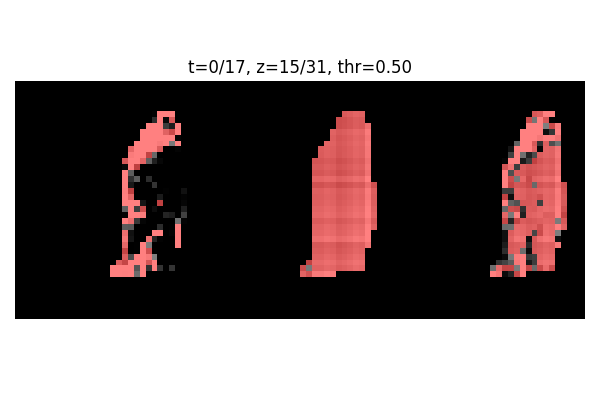

In [ ]:
# 2. Extract all density field with x,y,z,t 4D grid for visualization

grid_tensor_4d = char_domain.get_characteristic_geotimedomain()  # include time part
print(grid_tensor_4d.shape)
def predict_concentration_4d(c_net, pts4, nx, ny, nz, nt, batch_size=200_000):
    out_list = []
    with torch.no_grad():
        for i in range(0, pts4.shape[0], batch_size):
            chunk = pts4[i:i+batch_size]
            pred = c_net(chunk)
            out_list.append(pred.cpu())
    C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    # C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    return C_flat

C_pred_4d = predict_concentration_4d(pinn_model.ad_dc_net.c_net, grid_tensor_4d, nx, ny, nz, len(t), batch_size=200_000)
# Back to physical units
C_pred_4d *= c_dataset.C_star
print("Pred shape:", C_pred_4d.shape, "True shape:", data.shape)  # (nx, ny, nz, nt)

_ = draw_nifti_slices_with_time(C_pred_4d, data, mask)
# try calculate loss with true data
# from sklearn.metrics import mean_squared_error
# mse_overall = mean_squared_error(data.flatten(), C_pred_4d.flatten())


In [ ]:
# visualized filter points from all dataset.
if hasattr(c_dataset, "filter_mask"):
    # get all point from X_train;
    xyz = char_domain.recover_length_numpy(c_dataset.X_train[0].numpy()) / char_domain.pixdim
    t = char_domain.recover_time_index(c_dataset.X_train[1].numpy())
    vals = torch.ones((t.shape[0], 1))
    volume_seq = char_domain.points_to_geotimevolume(np.hstack((xyz, t)), vals.numpy())
    draw_nifti_slices_with_time(volume_seq, None, char_domain.mask)

In [ ]:
# get intial velocity field in cell/min for export
init_vx = initial_velocity_field[:,:,:,0]
init_vy = initial_velocity_field[:,:,:,1]
init_vz = initial_velocity_field[:,:,:,2]
# Export velocity to .mat format so that we could run GLAD using matlab
# the rOMT code require velocity reshaped to N*3 x 1, with unit cell/min
save_velocity_mat(init_vx,init_vy,init_vz,pixdim, 
                  D=pinn_model.ad_dc_net.D.item() if not cfg.use_DTI else pinn_model.ad_dc_net.D_normalized.item(), 
                  use_DTI=cfg.use_DTI,path=f"{cfg.result_folder}/predict_velocity.mat")

(491520, 1)
